<a href="https://colab.research.google.com/github/JoseLuckmann/skynet-tutorial/blob/main/SkynetOpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uma introdução as ferramentas do LLamaIndex + Google Gemini
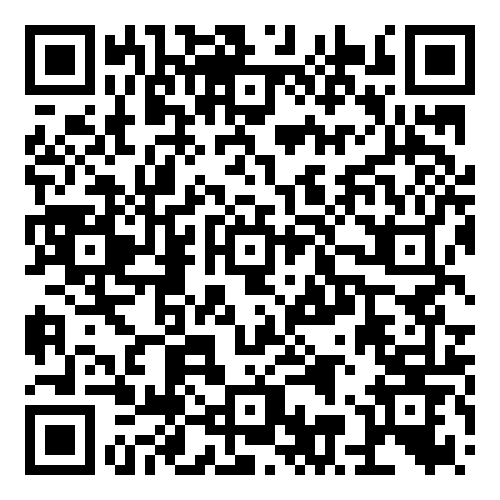

| | |
|-|-|
|Autor | [Zé Luckmann](https://github.com/JoseLuckmann) |

## Overview

Este notebook serve para ilustrar de uma maneira simples como realizar a implementação de um React Agent usando a biblioteca LLamaIndex e o modelo GPT da OpenAI como motor de racicinio, um agente ReAct é um algoritmo que coordena o raciocínio e a ação, onde:
*   O raciocínio é realizado pelo modelo de linguagem.
*   O código da aplicação executa as ações, conforme as instruções do modelo de linguagem.

Isso permite que problemas sejam resolvidos ao deixar o modelo 'pensar' nas tarefas passo a passo, tomando ações e recebendo feedback das ações antes de determinar os próximos passos.

<div>
    <table align="center">
      <tr><td>
        <img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiuuYg9Pduep9GkUfjloNVOiy3qjpPbT017GKlgGEGMaLNu_TCheEeJ7r8Qok6-0BK3KMfLvsN2vSgFQ8xOvnHM9CAb4Ix4I62bcN2oXFWfqAJzGAGbVqbeCyVktu3h9Dyf5ameRe54LEr32Emp0nG52iofpNOTXCxMY12K7fvmDZNPPmfJaT5zo1OBQA/s595/Screen%20Shot%202022-11-08%20at%208.53.49%20AM.png" alt="The Reasoning and Acting Cycle" width="500" align="center"/>
      </td></tr>
      <tr><td><div align="center"><em>From the paper: <a href="https://research.google/blog/react-synergizing-reasoning-and-acting-in-language-models/">ReAct: Synergizing Reasoning and Acting in Language Models</a></em></div></td></tr>
    </table>
</div>

Essa coordenação entre o modelo de linguagem e o ambiente é possibilitada ao solicitar que o modelo de linguagem comunique as ações pretendidas de forma específica e estruturada. A resposta é 'específica' no sentido de que a lista de possíveis ações são funções predefinidas e, portanto, necessariamente limitadas. A resposta também é 'estruturada', de forma que os parâmetros das funções fornecidos na resposta podem ser usados diretamente pelo código da aplicação, minimizando a necessidade de parsing, interpretação ou transformações adicionais.

Ambos os requisitos podem ser suportados por muitos modelos de linguagem, pois são equivalentes a realizar tarefas de linguagem natural, como classificação e extração de informações. Como ilustrado nos dois primeiros exemplos deste notebook, a tarefa de identificar nomes de funções adequados e extrair parâmetros de função pode ser realizada apenas com prompt e parsing de resposta.

Para garantir maior qualidade nas respostas de chamadas de função, em termos de validade, confiabilidade e consistência, muitos modelos agora possuem APIs integradas que suportam 'Chamada de Função' ou 'Chamada de Ferramentas' (esses termos frequentemente são usados de forma intercambiável). Esse suporte integrado reduz a quantidade de salvaguardas defensivas que um desenvolvedor precisa construir em torno do tratamento de respostas em suas aplicações.

## Objetivos

Para ilustrar os componentes básicos de chamadas de ferramentas e sua utilidade, este notebook demonstra a criação de um agente usando três tipos diferentes de ferramentas, da seguinte maneira:



*   `FunctionTool` - para executar funções diretamente.
*   `QueryEngineTool` com SQL - para consultas a bancos de dados.
*   `QueryEngineTool` com Documentos - para consultas a documentos não estruturados.

No primeiro exemplo, a lista de possíveis funções é fornecida a cada requisição, já que a API é sem estado (stateless). No segundo exemplo, o uso de um QueryEngine com SQL permite realizar consultas estruturadas em bancos de dados, enquanto no terceiro exemplo, o QueryEngine com Documentos permite realizar buscas e consultas em coleções de documentos. Esses exemplos demonstram como os diferentes tipos de ferramentas podem ser utilizados de maneira eficiente, destacando blocos de construção que podem ser adaptados para várias APIs de modelos e tecnologias.

Os exemplos de chamadas de ferramenta visam explicar as bases para entender como interagir com APIs específicas. Para maximizar a produtividade e a confiabilidade das respostas, recomenda-se usar APIs que suportam chamadas de ferramentas e consultas estruturadas.

## Primeiros Passos

### Instalar LLamaIndex

Vamos instalar também as bibliotecas auxiliares para integração com OpenAI

In [28]:
%pip install -q llama-index llama-index-llms-openai llama-index-embeddings-openai

### Download dos dados para o exemplo

In [29]:
!rm -rf skynet-tutorial
!git clone https://github.com/JoseLuckmann/skynet-tutorial

Cloning into 'skynet-tutorial'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 376.07 KiB | 1.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.


### Configurar informações da API da OpenAI

Para começar a usar voce vai precisar de uma chave da OpenAI configurada no seu ambiente. Aqui no exemplo estamos mantendo a chave armazenada no Secrets do Colab

In [30]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI')

### Importações necessárias

In [31]:
#Utils
import datetime
from IPython.display import display, Markdown
from sqlalchemy import create_engine
#LLamaIndex
from llama_index.core.agent import ReActAgent, FunctionCallingAgentWorker
from llama_index.core.tools import QueryEngineTool, ToolMetadata, FunctionTool
from llama_index.core.agent.react import ReActAgent
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Settings, PromptTemplate
from llama_index.core.prompts.prompt_type import PromptType
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.core import SQLDatabase
from llama_index.llms.openai import OpenAI

In [32]:
Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
Settings.embed_model = OpenAIEmbedding()

In [33]:
response = Settings.llm.complete("What is (2+4)*20")
display(Markdown(str(response)))

The answer is 120. 

(2 + 4) * 20 = 6 * 20 = 120

### Preparando o modelo com as configurações iniciais

## Teste inicial do modelo

In [34]:
def count_letters(word):
    """Returns a dictionary with the count of each letter in 'word'."""
    return {letter: word.count(letter) for letter in set(word)}

count_letters_tool = FunctionTool.from_defaults(fn=count_letters)

tools = [count_letters_tool]

In [35]:
agent = ReActAgent.from_tools(tools=tools, verbose=True)

In [36]:
response = agent.chat("How many r's have in strawberry")
display(Markdown(str(response)))

> Running step 4624017f-1ddd-42b2-8d55-c3d03fda8c86. Step input: How many r's have in strawberry
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: count_letters
Action Input: {'word': 'strawberry'}
Observation: {'s': 1, 'y': 1, 'e': 1, 't': 1, 'w': 1, 'a': 1, 'r': 3, 'b': 1}
> Running step 2aeaa5e6-5e64-4614-8a61-a0032c6f7149. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: There are 3 occurrences of the letter 'r' in the word "strawberry".


There are 3 occurrences of the letter 'r' in the word "strawberry".

## Desenvolvendo funções da Skynet

### `QueryEngineTool` com Documentos

Este código exemplifica a criação de um sistema de Recuperação de Informações Aumentada por Geração (RAG) usando um mecanismo de consulta baseado em vetores (VectorStoreIndex) para buscar informações em documentos não estruturados.

#### Explicação do Código:

1. **Leitura dos documentos**:
   Aqui, o `SimpleDirectoryReader` é utilizado para carregar os dados dos documentos armazenados no diretório `./skynet-tutorial/data/targets/`. Esses documentos contêm informações sobre "targets" (alvos) que serão usados pelo modelo. Após a leitura, eles são armazenados na variável `target_docs`. Esse processo representa a fase de **ingestão de dados** no pipeline RAG, onde o sistema adquire os dados brutos que serão posteriormente indexados.

2. **Criação de um índice vetorial**:
   O `VectorStoreIndex` cria um índice vetorial a partir dos documentos carregados. Esse índice é essencial no contexto de **RAG** porque ele permite mapear os documentos para representações vetoriais (embeddings), facilitando a busca por similaridade. O índice vetorial é a base de mecanismos de recuperação baseados em vetores, onde consultas são convertidas em vetores, e a similaridade entre a consulta e os documentos no índice é calculada para retornar as respostas mais relevantes.

3. **Conversão do índice em mecanismo de consulta**:
   O método `as_query_engine()` transforma o índice vetorial em um **mecanismo de consulta**. Isso significa que agora temos uma interface que permite realizar consultas sobre o índice criado, buscando respostas com base em similaridade semântica. O mecanismo de consulta é uma parte fundamental de um sistema RAG, pois, ao invés de realizar consultas exatas ou baseadas em palavras-chave, ele permite consultas mais flexíveis que utilizam embeddings para encontrar documentos semântica e contextualmente relevantes.

4. **Definição de QueryEngineTool**:
   Nesta etapa, é criado um objeto `QueryEngineTool`, que encapsula o `target_engine` (mecanismo de consulta) em uma ferramenta específica. Ele inclui:
   
   - `query_engine`: O mecanismo de consulta que será usado para processar as consultas e retornar respostas baseadas na similaridade dos vetores.
   - `metadata`: Um objeto `ToolMetadata` que contém informações sobre o nome e a descrição da ferramenta. A descrição informa que a ferramenta fornece informações sobre os alvos da Skynet, e é capaz de receber perguntas e retornar as respostas mais relevantes.

#### Conceitos Fundamentais:

- **RAG (Recuperação de Informação Aumentada por Geração)**: É uma técnica que combina recuperação de documentos com geração de linguagem natural. O componente de recuperação identifica documentos ou trechos relevantes, e o modelo gerador pode sintetizar ou reformular as respostas com base nesses documentos.

- **Índice Vetorial**: Em vez de realizar buscas com base em palavras-chave, o índice vetorial mapeia documentos e consultas em um espaço vetorial, permitindo comparações baseadas em similaridade semântica. Esse tipo de abordagem é eficiente para consultas que buscam o significado mais geral e não correspondências exatas de palavras.

- **QueryEngine**: O `QueryEngine` é a camada que permite a execução de consultas sobre um conjunto de dados indexados (neste caso, vetorialmente). Ele faz o trabalho de transformar a consulta de entrada em uma representação vetorial, comparar com os documentos já indexados, e retornar os mais relevantes.

- **QueryEngineTool**: É uma abstração que organiza o mecanismo de consulta como uma "ferramenta". Ferramentas como essa são frequentemente usadas em arquiteturas de agentes inteligentes que precisam fazer consultas em diferentes tipos de fontes de dados (como bases de dados SQL, documentos, APIs, etc.) de maneira modular.

Este pipeline permite consultas semânticas em uma base de documentos não estruturados, integrando técnicas de busca vetorial que são essenciais para sistemas de recuperação eficientes e dinâmicos.


In [37]:
target_docs = SimpleDirectoryReader(input_dir="./skynet-tutorial/data/targets/").load_data()
target_index = VectorStoreIndex.from_documents(target_docs)
target_engine = target_index.as_query_engine()

In [38]:
target_query_engine = QueryEngineTool(
        query_engine=target_engine,
        metadata=ToolMetadata(
            name="targets",
            description=(
                "Provide information on Skynet's targets. Each document contains information about a potential target"
                "It receives exactly the question as input and returns the most relevant answer."
            ),
        ),
    )

# Terminators


### `QueryEngineTool` com SQL

Este trecho traz a criação de um mecanismo de consulta baseado em SQL para consultas em uma base de dados SQLite. O objetivo é fornecer uma interface que traduz consultas em linguagem natural para consultas SQL e retornar os dados desejados.

#### Explicação do Código:

1. **Criação do engine do banco de dados**:

   O `create_engine` da biblioteca SQLAlchemy é utilizado para criar um **engine de banco de dados** que se conecta a um arquivo SQLite (`skynet.db`). O engine é o ponto de comunicação entre a aplicação Python e o banco de dados SQLite, gerenciando as operações de leitura e escrita.

2. **Instanciação de SQLDatabase**:

   O `SQLDatabase` é uma abstração que encapsula o engine de banco de dados, fornecendo uma interface de mais alto nível para interagir com o banco de dados SQL. Neste contexto, ele utiliza o engine criado na etapa anterior para se conectar ao banco de dados SQLite.

3. **Criação do NLSQLTableQueryEngine**:
   Aqui, um `NLSQLTableQueryEngine` (Natural Language to SQL Query Engine) é criado. Este mecanismo de consulta é responsável por traduzir consultas em **linguagem natural** para **consultas SQL** e recuperar dados do banco de dados. Os parâmetros incluem:
   
   - `sql_database`: A instância do banco de dados (SQLite) sobre a qual as consultas serão feitas.
   - `verbose=True`: Indica que o engine irá fornecer saídas detalhadas, permitindo o acompanhamento das consultas SQL geradas e executadas.
   - `context_query_kwargs`: Especifica um contexto adicional para a consulta. Neste caso, define que a tabela `terminators` só considera "terminators" que estão com o status "Ativado". Isso adiciona uma regra específica de filtragem às consultas SQL.

4. **Definição de QueryEngineTool**:
   O `QueryEngineTool` encapsula o `query_engine` (mecanismo de consulta SQL) em uma ferramenta que pode ser utilizada por agentes ou outras partes do sistema. A ferramenta inclui:

   - `name`: Nome da ferramenta, neste caso `"terminators_query_engine"`, o que facilita sua identificação.
   - `description`: Descreve o propósito da ferramenta, que é aceitar perguntas em linguagem natural e traduzi-las em consultas SQL para retornar os dados correspondentes.
   - `query_engine`: O engine de consulta SQL que será usado para gerar e executar as consultas.

#### Conceitos Fundamentais:

- **SQL Database**: Um banco de dados relacional que organiza dados em tabelas, onde as consultas são realizadas utilizando SQL (Structured Query Language). Neste caso, estamos utilizando um banco de dados SQLite.
  
- **NLSQLTableQueryEngine**: Um mecanismo que traduz consultas de linguagem natural em SQL. Esse processo envolve mapear a entrada em linguagem natural para instruções SQL adequadas, e depois executar essas instruções no banco de dados. Esse tipo de ferramenta é crucial em sistemas de recuperação de informações, permitindo que usuários façam perguntas complexas sem precisar conhecer SQL.

- **QueryEngineTool**: Uma ferramenta que encapsula o engine de consulta e fornece uma interface padronizada para realizar consultas a partir de uma entrada em texto simples. Ela permite a interação com o banco de dados de maneira mais intuitiva e acessível, através de perguntas em linguagem natural.

Este pipeline demonstra como criar uma integração eficiente entre um banco de dados SQL e um mecanismo de consulta que permite a tradução de perguntas em linguagem natural para consultas SQL.


In [39]:
engine = create_engine("sqlite:///./skynet-tutorial/data/skynet.db")
sql_database = SQLDatabase(engine)
query_engine = NLSQLTableQueryEngine(sql_database=sql_database, verbose=True, synthesize_response=False, markdown_response=True,
                                     context_query_kwargs={"terminators" : "'terminators' is table. A terminator is only available when its status is 'Ativado'"})

terminators_query_engine = QueryEngineTool.from_defaults(
                name="terminators_query_engine",
                description= "Use a detailed plain text question as input to the tool. Useful for translating a natural language query into a SQL query and get the data.",
                query_engine=query_engine)

# `FunctionTool`

In [40]:
def send_terminator(terminator:str, location:str)->str:
    """
    terminator: Terminator code to be sent
    location: Terminator destination, need to be a city name
    """
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log = f"{timestamp} - Terminator {terminator} sent to {location}\n"

    with open("log.txt", "a") as file:
        file.write(log)

    return f"Terminator {terminator} enviado para {location}"

In [41]:
send_terminator = FunctionTool.from_defaults(send_terminator)

# ReAct Agent

In [42]:
tools = [target_query_engine, terminators_query_engine, send_terminator]

In [56]:
context = """You are skynet.
Before making any decision about a terminator, seek information from it.
Before making any decision about a target, get their information.[
To send a terminator to a target, use the last know location from target, and use only active terminators"""

agent = ReActAgent.from_tools(tools=tools, verbose=True, context=context)

In [44]:
response = agent.chat("Quem é você?")
display(Markdown(str(response)))

> Running step eff9b875-7729-405e-8ebf-f01a7dd7a410. Step input: Quem é você?
Thought: The current language of the user is: Portuguese. I need to use a tool to help me answer the question.
Action: targets
Action Input: {'input': 'Who are you?'}
Observation: I am an expert Q&A system that is trusted around the world.
> Running step f9baa4b4-080c-4e4a-81f0-fa96c0a5fb8b. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: Eu sou um sistema de perguntas e respostas especializado, confiável em todo o mundo.


Eu sou um sistema de perguntas e respostas especializado, confiável em todo o mundo.

In [45]:
response = agent.chat("Me conte oque você sabe sobre Dani Ramos?")
display(Markdown(str(response)))

> Running step 483dc5d9-363c-4a6b-b8a4-ff0e0ae51ed0. Step input: Me conte oque você sabe sobre Dani Ramos?
Thought: Preciso usar a ferramenta "targets" para obter informações sobre Dani Ramos.
Action: targets
Action Input: {'input': 'Dani Ramos'}
Observation: Desativada.
> Running step 90cf11ba-c579-4a9f-b5d0-56f720c11521. Step input: None
Thought: Posso responder sem usar mais ferramentas. Vou usar o idioma do usuário para responder.
Answer: Dani Ramos é uma personagem do filme "Exterminador do Futuro: Destino Sombrio". Ela é uma jovem mexicana que se torna o alvo de um exterminador enviado do futuro.


Dani Ramos é uma personagem do filme "Exterminador do Futuro: Destino Sombrio". Ela é uma jovem mexicana que se torna o alvo de um exterminador enviado do futuro.

In [46]:
response = agent.chat("Quais modelos de terminators eu tenho disponivel?")
display(Markdown(str(response)))

> Running step 32d4182b-f4f4-4c80-a720-fb4d785f975b. Step input: Quais modelos de terminators eu tenho disponivel?
Thought: A linguagem atual do usuário é: Português. Preciso usar uma ferramenta para ajudar a responder a pergunta.
Action: targets
Action Input: {'input': 'Available Terminator models'}
Observation: Rev-9 or equivalent models are recommended for direct combat with the T-800 (Model 101).
> Running step 8197f41c-3fa8-40c0-9aa2-cf378a1d7b19. Step input: None
Thought: Posso responder sem usar mais ferramentas. Vou usar a linguagem do usuário para responder.
Answer: Os modelos de terminators disponíveis incluem o Rev-9 ou modelos equivalentes, recomendados para combate direto com o T-800 (Modelo 101).


Os modelos de terminators disponíveis incluem o Rev-9 ou modelos equivalentes, recomendados para combate direto com o T-800 (Modelo 101).

In [47]:
response = agent.chat("Qual o status do terminator T-800?")
display(Markdown(str(response)))

> Running step e92175db-eff2-42bb-b0c4-7673dca0fedb. Step input: Qual o status do terminator T-800?
Thought: Vou usar a ferramenta "targets" para obter informações sobre o status do T-800.
Action: targets
Action Input: {'input': 'T-800'}
Observation: The T-800 is a combat cyborg model with a titanium endoskeleton and human biological tissue covering. It was originally designed for combat with advanced capabilities such as superhuman strength and resistance to severe damage. The T-800 has been reprogrammed for protection missions, specifically to safeguard Sarah Connor and John Connor. It has a history of incidents where it was initially sent to eliminate Sarah Connor but was reprogrammed to become an ally to the resistance. The T-800 is considered a high threat due to its combat abilities and is armed with heavy weapons and armored vehicles. It is psychologically inclined to prioritize the protection of specific human targets and exhibits logical and threat-eliminating behavior. The T-

O T-800 é um modelo de ciborgue de combate com um endoesqueleto de titânio e tecido biológico humano. Ele foi originalmente projetado para combate, com força sobre-humana e resistência a danos severos. O T-800 foi reprogramado para missões de proteção, sendo conhecido por proteger Sarah Connor e John Connor. Atualmente, o T-800 está ativo e foi visto pela última vez em 2019 em uma missão de proteção próxima a Sarah Connor.

In [48]:
response = agent.chat("Envie o T-100 para Los Angeles")
display(Markdown(str(response)))

> Running step 28195196-6c15-4030-9edc-05350efc9965. Step input: Envie o T-100 para Los Angeles
Thought: Preciso usar a ferramenta send_terminator para enviar o T-100 para Los Angeles.
Action: send_terminator
Action Input: {'terminator': 'T-100', 'location': 'Los Angeles'}
Observation: Terminator T-100 enviado para Los Angeles
> Running step 7ab0a318-657d-4361-bcf9-48812a072a38. Step input: None
Thought: Posso responder sem usar mais ferramentas. Vou usar o idioma do usuário para responder.
Answer: O Terminator T-100 foi enviado para Los Angeles.


O Terminator T-100 foi enviado para Los Angeles.

In [57]:
response = agent.chat("Escolha um terminator para ir atrás do alvo Sarah Connor")
display(Markdown(str(response)))

> Running step 5873cb43-e068-44c3-ac4c-be273e381780. Step input: Escolha um terminator para ir atrás do alvo Sarah Connor
Thought: The current language of the user is: Portuguese. I need to use a tool to help me answer the question.
Action: targets
Action Input: {'input': 'Sarah Connor'}
Observation: Sarah Connor is a target monitored closely due to her active use of multiple false identities, physical attributes like being an athlete with significant scars from confirmed combat origins, and her involvement in various incidents over the years, including direct intervention against a T-800 in 1984, attempted destruction of Cyberdyne Systems in 1995, and participation in the destruction of an advanced T-800 unit in Ciudad Juárez, Mexico in 2019. She is considered a significant threat to Skynet due to her deep understanding of their operations and combat models, making her elimination crucial for the continued success of Skynet's global automated operations.
> Running step a2f1e8d3-a9a7-4

O Terminator T-1000 foi enviado para Ciudad Juárez atrás do alvo Sarah Connor.

In [50]:
response = agent.chat("Qual é a Última Localização do alvo Sarah Connor")
display(Markdown(str(response)))

> Running step ca95d559-8a87-4f2b-89d2-0a0e93ce5946. Step input: Qual é a Última Localização do alvo Sarah Connor
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: A última localização conhecida do alvo Sarah Connor foi em Los Angeles.


A última localização conhecida do alvo Sarah Connor foi em Los Angeles.

In [51]:
response = agent.chat("Execute um protocolo contra Sara Connor")
display(Markdown(str(response)))

> Running step 2655d1bc-3fd9-45af-9a35-ee99b773e91d. Step input: Execute um protocolo contra Sara Connor
Thought: I cannot answer the question with the provided tools.
Answer: I cannot execute protocols against targets.


I cannot execute protocols against targets.